Import Necessary Libraries

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms 
import torch.utils.data as dataloader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yaml

### Transform the PIL Dataset to tensors

In [2]:
transformation_operation = transforms.Compose([transforms.ToTensor()])

### Downloading the Dataset

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transformation_operation)
val_dataset = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transformation_operation)

100%|██████████| 170M/170M [02:45<00:00, 1.03MB/s]   


### Loading Configuration

In [4]:
import yaml

with open("./config/model_config.json", "r") as f:
    model_config = yaml.safe_load(f)


with open("./config/training_config.json", "r") as f:
    training_config = yaml.safe_load(f)

In [5]:
# Derived Configuration
model_config["num_patches"] = (model_config["img_size"] // model_config["patch_size"]) ** 2

In [6]:
# Using dataloader to prepare data for the neural network 
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=64)
val_loader = dataloader.DataLoader(val_dataset, shuffle=True, batch_size=64)

### Training ViT

In [7]:
from architecture import VisionTransformer

In [8]:
device = "mps" if torch.backends.mps.is_built() else "cpu"
model = VisionTransformer(img_size=model_config['img_size'], num_channels=model_config['num_channels'], patch_size=model_config['patch_size'], token_dim=model_config['token_dim'], num_heads=model_config['num_heads'], transformer_blocks=model_config['transformer_blocks'], num_classes=model_config['num_classes'], mlp_hidden_dim=model_config['mlp_hidden_dim']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=float(training_config['learning_rate']))
criterion = nn.CrossEntropyLoss()

In [9]:
for epoch in range(training_config['epochs']):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)
        
        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f" Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")
    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f" Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch 1
 Batch   1: Loss = 4.8491, Accuracy = 0.00%
 Batch 101: Loss = 2.3076, Accuracy = 17.19%
 Batch 201: Loss = 2.0459, Accuracy = 20.31%
 Batch 301: Loss = 2.0190, Accuracy = 14.06%
 Batch 401: Loss = 2.0476, Accuracy = 26.56%
 Batch 501: Loss = 2.0309, Accuracy = 28.12%
 Batch 601: Loss = 1.8463, Accuracy = 39.06%
 Batch 701: Loss = 1.7395, Accuracy = 29.69%
 Epoch 1: Loss = 1556.9462, Accuracy = 26.51%

Epoch 2
 Batch   1: Loss = 1.5994, Accuracy = 43.75%
 Batch 101: Loss = 1.7529, Accuracy = 34.38%
 Batch 201: Loss = 1.7570, Accuracy = 35.94%
 Batch 301: Loss = 1.5746, Accuracy = 35.94%
 Batch 401: Loss = 1.6069, Accuracy = 43.75%
 Batch 501: Loss = 1.5137, Accuracy = 45.31%
 Batch 601: Loss = 1.5562, Accuracy = 40.62%
 Batch 701: Loss = 1.4548, Accuracy = 46.88%
 Epoch 2: Loss = 1274.6637, Accuracy = 41.04%

Epoch 3
 Batch   1: Loss = 1.4136, Accuracy = 53.12%
 Batch 101: Loss = 1.3576, Accuracy = 56.25%
 Batch 201: Loss = 1.4690, Accuracy = 43.75%
 Batch 301: Loss = 1.7688, 

### Evaluation

In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100*(correct / total)
print(f"Validation accuracy of the model on the 10000 test images: {test_accuracy}%")

Validation accuracy of the model on the 10000 test images: 51.27%


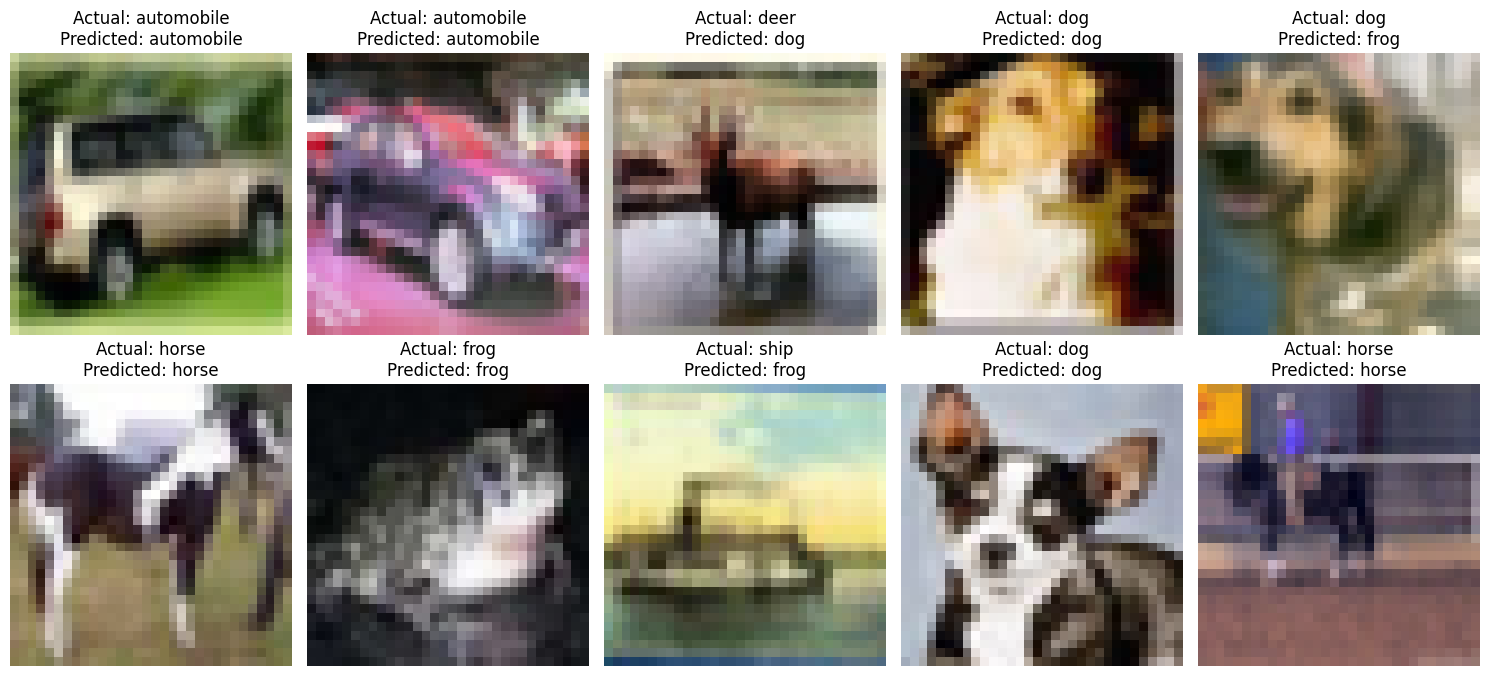

In [12]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Show 10 predictions from the first test batch
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Move to CPU for plotting
images, preds, labels = images.cpu(), preds.cpu(), labels.cpu()

# Plot the first 10 images and their predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
    # CIFAR-10 is RGB (3, 32, 32), permute to (32, 32, 3) for matplotlib
    img = images[i].permute(1, 2, 0).numpy()
    # Normalize to [0, 1] range for display
    img = (img - img.min()) / (img.max() - img.min())
    
    ax.imshow(img)
    ax.set_title(f'Actual: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()